In [1]:
from dask.distributed import Client

client = Client("tls://localhost:8786")
client

<Client: 'tls://192.168.134.197:8786' processes=410 threads=820, memory=2.29 TiB>

### Loading full analysis fileset

In [2]:
from os import listdir

# TODO: replace with UL sample once we have it
with open('data/2017_preUL_nano/HHToBBVVToBBQQQQ_cHHH1.txt', 'r') as file:
    filelist = [f[:-1].replace('/eos/uscms/', 'root://xcache//') for f in file.readlines()]   # need to use xcache redirector at Nebraksa coffea-casa

fileset = {
    '2017_HHToBBVVToBBQQQQ_cHHH1': filelist
}

ignore_samples = ['GluGluHToTauTau_M125_TuneCP5_13TeV-powheg-pythia8', 
                  'GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8',
                  'ST_tW_antitop_5f_DS_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8',
                  'ST_tW_top_5f_DS_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8']

for sample in listdir('data/2017_UL_nano/'):
    if sample[-4:] == '.txt' and sample[:-4] not in ignore_samples:
        with open(f'data/2017_UL_nano/{sample}', 'r') as file:
            replace_string = '/hadoop/cms/' if 'JetHT' in sample else '/eos/uscms/'
            filelist = [f[:-1].replace(replace_string, 'root://xcache//') for f in file.readlines()]   # need to use xcache redirector at Nebraksa coffea-casa
        fileset['2017_' + sample[:-4].split('_TuneCP5')[0]] = filelist

In [3]:
testing_fileset = {key: filelist[:2] for key, value in fileset.items()}
testing_fileset

{'2017_HHToBBVVToBBQQQQ_cHHH1': ['root://xcache//store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225007/0000/nano_mc2017_1-1.root',
  'root://xcache//store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225007/0000/nano_mc2017_1-10.root'],
 '2017_QCD_HT1000to1500': ['root://xcache//store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225007/0000/nano_mc2017_1-1.root',
  'root://xcache//store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225007/0000/nano_mc2017_1-10.root'],
 '2017_JetHT_Run2017F-09Aug2019_

### Cross sections

In [4]:
import json
with open('data/xsecs.json') as f:
    xsecs = json.load(f)
    
for key, value in xsecs.items():
    if type(value) == str:
        xsecs[key] = eval(value)

Checking that we have xsecs for all the samples (will give warnings if not)

In [5]:
for key in fileset.keys():
    if 'JetHT' not in key:
        dname = key.split('2017_')[1]
        if dname not in xsecs:
            import warnings
            warnings.warn(f"cross section not found for {dname}")
#         else: print(f'{dname}: {xsecs[dname]}')

In [6]:
import awkward as ak
from coffea.processor import ProcessorABC, column_accumulator
import numpy as np
from coffea.analysis_tools import PackedSelection
import pickle


class bbVVSkimmer(ProcessorABC):
    """ Skims nanoaod files, saving selected branches and events passing preselection cuts (and triggers for data), for preliminary cut-based analysis and BDT studies """
    # TODO: do ak8, ak15 sorting for hybrid case

    def __init__(self, xsecs):
        super(bbVVSkimmer, self).__init__()
        
        # in pb^-1
        self.LUMI = {'2017': 40000}

        # in pb
        self.XSECS = xsecs

        self.HLTs = {
            '2017':   [
                        'PFJet500',
                        'AK8PFJet400',
                        'AK8PFJet500',
                        'AK8PFJet360_TrimMass30',
                        'AK8PFJet380_TrimMass30',
                        'AK8PFJet400_TrimMass30',
                        'AK8PFHT750_TrimMass50',
                        'AK8PFHT800_TrimMass50',
                        'PFHT1050',
                        # 'AK8PFJet330_PFAK8BTagCSV_p17'
                    ]
        }

        # key is name in nano files, value will be the name in the skimmed output
        self.skim_vars = {
            'FatJet': {
                'eta': 'Eta',
                'phi': 'Phi',
                'mass': 'Mass',
                'msoftdrop': 'Msd',
                'pt': 'Pt',

                'particleNetMD_QCD': 'ParticleNetMD_QCD',
                'particleNetMD_Xbb': 'ParticleNetMD_Xbb',
                'particleNetMD_Xcc': 'ParticleNetMD_Xcc',
                'particleNetMD_Xqq': 'ParticleNetMD_Xqq',
                'particleNet_H4qvsQCD': 'ParticleNet_Th4q',
            },
            'FatJetAK15': {
                'eta': 'Eta',
                'phi': 'Phi',
                'mass': 'Mass',
                'msoftdrop': 'Msd',
                'pt': 'Pt',

                'ParticleNetMD_probQCD': 'ParticleNetMD_probQCD',
                'ParticleNetMD_probQCDb': 'ParticleNetMD_probQCDb',
                'ParticleNetMD_probQCDbb': 'ParticleNetMD_probQCDbb',
                'ParticleNetMD_probQCDc': 'ParticleNetMD_probQCDc',
                'ParticleNetMD_probQCDcc': 'ParticleNetMD_probQCDcc',
                'ParticleNetMD_probXbb': 'ParticleNetMD_probXbb',
                'ParticleNetMD_probXcc': 'ParticleNetMD_probXcc',
                'ParticleNetMD_probXqq': 'ParticleNetMD_probXqq',
                'ParticleNet_probHbb': 'ParticleNet_probHbb',
                'ParticleNet_probHcc': 'ParticleNet_probHcc',
                'ParticleNet_probHqqqq': 'ParticleNet_probHqqqq',
                'ParticleNet_probQCDb': 'ParticleNet_probQCDb',
                'ParticleNet_probQCDbb': 'ParticleNet_probQCDbb',
                'ParticleNet_probQCDc': 'ParticleNet_probQCDc',
                'ParticleNet_probQCDcc': 'ParticleNet_probQCDcc',
                'ParticleNet_probQCDothers': 'ParticleNet_probQCDothers',
            },
            'other': {
                'MET_pt': 'MET_pt'
            }
        }

        self.preselection_cut_vals = {'pt': 250, 'msd': 20}

        with open('processors/2017_pileupweight.pkl', 'rb') as filehandler:
            self.pileupweight_lookup = pickle.load(filehandler)
        

    def process(self, events):
        """ Returns skimmed events which pass preselection cuts (and triggers if data) and with the branches listed in self.skim_vars """

        print("processing")
        
        year = events.metadata['dataset'][:4]
        dataset = events.metadata['dataset'][5:]

        n_events = len(events)
        isData = 'JetHT' in dataset
        selection = PackedSelection()


        def pad_val(arr, target, value, axis=0, to_numpy=True):
            ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=True), value)
            return ret.to_numpy() if to_numpy else ret


        # TODO: gen vars


        # triggers

        if isData:
            HLT_triggered = np.any(np.array([events.HLT[trigger] for trigger in self.HLTs[year] if trigger in events.HLT.fields]), axis=0)
            selection.add('trigger', HLT_triggered)

        # pre-selection cuts
        # ORing ak8 and ak15 cuts

        preselection_cut = np.logical_or(   np.prod(pad_val((events.FatJet.pt > self.preselection_cut_vals['pt']) * (events.FatJet.msoftdrop > self.preselection_cut_vals['msd']), 2, False, axis=1), axis=1),
                                            np.prod(pad_val((events.FatJetAK15.pt > self.preselection_cut_vals['pt']) * (events.FatJetAK15.msoftdrop > self.preselection_cut_vals['msd']), 2, False, axis=1)
                                            , axis=1))
        selection.add('preselection', preselection_cut)

        # TODO: trigger SFs


        # select vars
        
        ak8FatJetVars = {f'ak8FatJet{key}': pad_val(events.FatJet[var], 2, -1, axis=1) for (var, key) in self.skim_vars['FatJet'].items()}
        ak15FatJetVars = {f'ak15FatJet{key}': pad_val(events.FatJetAK15[var], 2, -1, axis=1) for (var, key) in self.skim_vars['FatJetAK15'].items()}
        otherVars = {key: events[var.split('_')[0]]["_".join(var.split('_')[1:])].to_numpy() for (var, key) in self.skim_vars['other'].items()}
        
        import sys
        if sys.version_info[1] < 9: skimmed_events = {**ak8FatJetVars, **ak15FatJetVars, **otherVars}
        else: skimmed_events = ak8FatJetVars | ak15FatJetVars | otherVars  # this is fancier
            
        # particlenet h4q vs qcd, xbb vs qcd

        skimmed_events['ak8FatJetParticleNetMD_Txbb'] = pad_val(events.FatJet.particleNetMD_Xbb / (events.FatJet.particleNetMD_QCD + events.FatJet.particleNetMD_Xbb), 2, -1, axis=1)
        skimmed_events['ak15FatJetParticleNetMD_Txbb'] = pad_val(events.FatJetAK15.ParticleNetMD_probXbb / (events.FatJetAK15.ParticleNetMD_probQCD + events.FatJetAK15.ParticleNetMD_probXbb), 2, -1, axis=1)
        skimmed_events['ak15FatJetParticleNet_Th4q'] = pad_val(events.FatJetAK15.ParticleNet_probHqqqq / (  events.FatJetAK15.ParticleNet_probHqqqq +
                                                                                                    events.FatJetAK15.ParticleNet_probQCDb +
                                                                                                    events.FatJetAK15.ParticleNet_probQCDbb +
                                                                                                    events.FatJetAK15.ParticleNet_probQCDc +
                                                                                                    events.FatJetAK15.ParticleNet_probQCDcc +
                                                                                                    events.FatJetAK15.ParticleNet_probQCDothers
                                                                                                    ), 2, -1, axis=1)

        # calc weights

        skimmed_events['weight'] = np.ones(n_events) if isData else (events.genWeight * self.pileupweight_lookup(events.Pileup.nPU)).to_numpy()

        # apply selections

        skimmed_events = {
            key: column_accumulator(value[selection.all(*selection.names)]) for (key, value) in skimmed_events.items()
        }

        return {
            year: {
                dataset: {
                        'nevents': n_events,
                        'skimmed_events': skimmed_events,
                    }
                }
        }


    def postprocess(self, accumulator):
        for year, datasets in accumulator.items():
            for dataset, output in datasets.items():
                output['skimmed_events'] = {
                    key: value.value for (key, value) in output['skimmed_events'].items()
                }

                if 'JetHT' not in dataset:
                    weight = 1 / output['nevents']
                    if dataset in self.XSECS:
                        weight *= self.LUMI[year] * self.XSECS[dataset]
                    output['skimmed_events']['weight'] *= weight

        return accumulator

In [15]:
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import time

# import processors

# import shutil
# shutil.make_archive("processors", "zip", base_dir="processors")
# client.upload_file("processors.zip");

tic = time.time()

exe_args = {
    "client": client,
    "savemetrics": True,
    "schema": NanoAODSchema,
    "align_clusters": True,
    "skipbadfiles": True
}

# # trigger SF filelist
# with open('data/SingleMuon_2017.txt', 'r') as file:
#     filelist = [f[:-1].replace('redirector.t2.ucsd.edu', 'xcache') for f in file.readlines()]   # redirector must be replaced xcache at Nebraksa coffea-casa

# trigger_SF_fileset = {'2017': filelist}

print("Waiting for at least one worker...")
client.wait_for_workers(1)

print("Found at least one worker...")

out, metrics = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=bbVVSkimmer(xsecs),   # replace with your processor
    executor=processor.dask_executor,
    executor_args=exe_args,  
#     maxchunks=10
)

elapsed = time.time() - tic

# can customize this
# print(f"num: {out['num'].view(flow=True)}")
# print(f"den: {out['den'].view(flow=True)}")
# print(out)

print(f"Metrics: {metrics}")
print(f"Finished in {elapsed:.1f}s")

Waiting for at least one worker...
Found at least one worker...
[####################################    ] | 92% Completed | 41min  4.3ss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
events = NanoEventsFactory.from_root('root://xcache//store/user/rkansal/PFNano/JetHT/Run2017B-09Aug2019_UL2017-v1_Jul8_21/210708_202653/0000/nano_data2017_137.root', schemaclass=NanoAODSchema).events()

In [12]:
'AK8PFJet360_TrimMass30' in events.HLT.fields

False

49.920114275132605

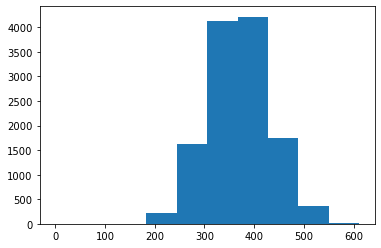

In [26]:
import matplotlib.pyplot as plt
plt.hist(out['2017']['HHToBBVVToBBQQQQ_cHHH1']['skimmed_events']['ak8FatJetPt'][:, 0]);
np.sum(out['2017']['HHToBBVVToBBQQQQ_cHHH1']['skimmed_events']['weight'])

In [28]:
len(out['2017']['HHToBBVVToBBQQQQ_cHHH1']['skimmed_events']['weight'])

12310

In [19]:
import pickle
from os.path import exists
out_file = 'outPickles/out_skimmed.pickle'   # make sure to change!!

if not exists(out_file):
    with open(out_file, 'wb') as filehandler:
        pickle.dump(out, filehandler)

NameError: name 'out' is not defined

In [16]:
out

NameError: name 'out' is not defined

## Saving trigger efficiencies

In [19]:
effs = out['num'] / out['den']

with open('corrections/trigEffs/AK15JetHTTriggerEfficiency_2017_2.hist', 'wb') as filehandler:
    pickle.dump(effs, filehandler)

In [14]:
# saving as a root THND - doesn't work for 3D histograms with uproot3... need pyroot?
import uproot3

ak15_trig_effs = uproot3.create('corrections/trigEffs/AK8JetHTTriggerEfficiency_2017.root')
ak15_trig_effs['efficiency_ptmass'] = effs.to_numpy(flow=True)

/opt/conda/lib/python3.8/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.8/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


In [1]:
import pickle
from os.path import exists
out_file = 'outPickles/out_skimmed.pickle'   # make sure to change!!

# if not exists(out_file):
with open(out_file, 'rb') as filehandler:
    out = pickle.load(filehandler)

In [2]:
out

{'2017': {'QCD_HT700to1000': {'nevents': 39746,
   'skimmed_events': {'ak8FatJetEta': array([[-0.20223999, -1.30688477],
           [-0.74560547,  0.14697266],
           [ 1.23095703, -1.69482422],
           ...,
           [-0.64782715, -1.16723633],
           [-1.15478516,  0.48590088],
           [-1.72900391, -1.51123047]]),
    'ak8FatJetPhi': array([[ 1.29345703, -1.96118164],
           [ 0.06089783, -3.08349609],
           [ 2.86425781, -0.25921631],
           ...,
           [-0.46148682,  1.29589844],
           [ 2.20263672, -1.12036133],
           [-2.84716797,  0.12435913]]),
    'ak8FatJetMass': array([[ 62.46875,  35.40625],
           [ 76.1875 ,  97.75   ],
           [106.5625 ,  49.6875 ],
           ...,
           [ 40.84375,  63.46875],
           [ 49.15625, 111.125  ],
           [ 82.     , 112.3125 ]]),
    'ak8FatJetMsd': array([[ 41.4375    ,   2.9375    ],
           [ 64.5       ,  89.9375    ],
           [104.8125    ,  36.71875   ],
           ...